In [85]:
import numpy as np
from matplotlib import pyplot as plt
print("test")

test


In [86]:
# Elements of symmetry groups are set transformations that leave an object invariant. \
# Symmetry groups are quaternion representations of point groups
# There are (naturally in 3D), 32 crystollographic point groups
# Our EBSD Nickel data exhibits Oh (m3m) cyrstallographic point group symmetry.
from orix.quaternion.symmetry import Oh

In [101]:
# Load and x-plane cross-section of a 3D EBSD microscope scan of Nickel unit crystal orientations 
all_data = np.load("Open_718_Test_hr_x_block_45.npy")
# Decrease computational burden for this excercise
data = all_data[50:70, 50:70]

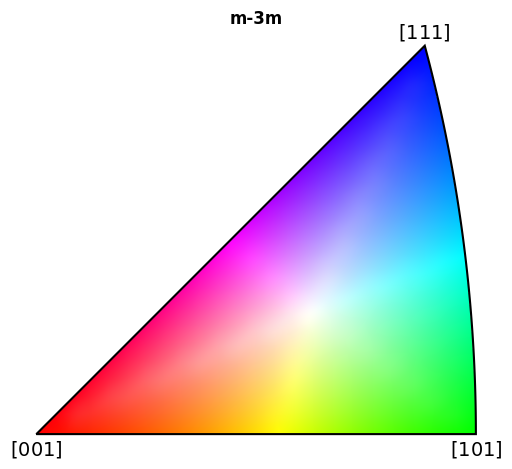

In [102]:
from orix import plot
plot.IPFColorKeyTSL(Oh).plot()

In [103]:
# import orix a PyPi library used for handling crystal orientation mapping data
from orix.quaternion import Orientation, OrientationRegion, Rotation

# Elements of symmetry groups are set transformations that leave an object invariant. \
# Symmetry groups are quaternion representations of point groups
# There are (naturally in 3D), 32 crystollographic point groups
# Our EBSD Nickel data exhibits Oh (m3m) cyrstallographic point group symmetry.
from orix.quaternion.symmetry import Oh

In [104]:
# Convert numpy quaternion data to orix Orientations
ori_all = Orientation(all_data)

ori = Orientation(data)
shape = ori.shape

ori = ori.flatten()
ori.symmetry = Oh
ori = ori.map_into_symmetry_reduced_zone()
print(ori.shape)

(400,)


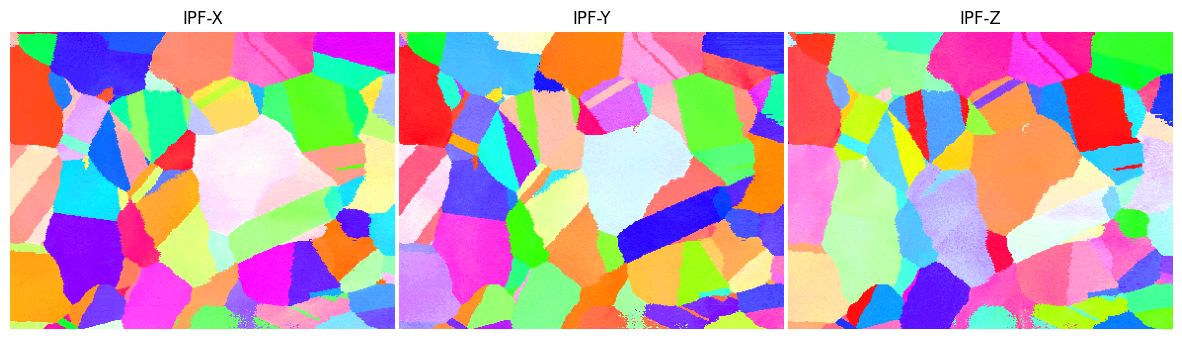

In [105]:
# Visualize EBSD data with inverse pole figure in the selected data region
from orix.vector import AxAngle, Vector3d
import matplotlib.pyplot as plt

ckey = plot.IPFColorKeyTSL(Oh)
directions = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
titles = ["X", "Y", "Z"]

fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.imshow(ckey.orientation2color(~ori_all))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# # Add color key
# ax_ipfkey = fig.add_axes(
#     [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
#     projection="ipf",
#     symmetry=ori.symmetry.laue,
# )
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)


In [106]:
from orix.quaternion.symmetry import C1
# Remove symmetry by setting to point group 1 (identity operation)
ori_without_symmetry = Orientation(ori.data, symmetry=C1)

# Misorientations
mori1 = (~ori_without_symmetry).outer(ori_without_symmetry)

# Misorientation angles
D1 = mori1.angle
print(D1)

[[0.         0.01745318 0.01745325 ... 0.93045259 0.93045259 1.18824638]
 [0.01745318 0.         0.02468242 ... 0.93542555 0.93542555 1.20433943]
 [0.01745325 0.02468242 0.         ... 0.9432315  0.9432315  1.19507018]
 ...
 [0.93045259 0.93542555 0.9432315  ... 0.         0.         1.04498298]
 [0.93045259 0.93542555 0.9432315  ... 0.         0.         1.04498298]
 [1.18824638 1.20433943 1.19507018 ... 1.04498298 1.04498298 0.        ]]


In [107]:
# Use Sklearn PyPi library for unsupervised clustering (DBSCAN)
# Use pyplot to plot fundamental region
from sklearn.cluster import DBSCAN
dbscan_naive = DBSCAN(eps=0.1, min_samples=2, metric="precomputed").fit(D1)
print("Labels: ", np.unique(dbscan_naive.labels_))

Labels:  [-1  0  1  2  3]


In [108]:
# Elements of symmetry groups are set transformations that leave an object invariant. \
# Symmetry groups are quaternion representations of point groups
# There are (naturally in 3D), 32 crystollographic point groups
# Our EBSD Nickel data exhibits Oh (m3m) cyrstallographic point group symmetry.
from orix.quaternion.symmetry import Oh

In [109]:
# Misorientations with symmetry
mori2 = (~ori).outer(ori)

mori2.symmetry = Oh
mori2 = mori2.map_into_symmetry_reduced_zone()

D2 = mori2.angle

In [110]:
dbscan = DBSCAN(
    eps=np.deg2rad(17), min_samples=2, metric="precomputed"
).fit(D2.astype(np.float32))
print("Labels:", np.unique(dbscan.labels_))

Labels: [-1  0  1  2]


In [111]:
# Colorisation & Animation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb
import matplotlib.animation as animation
import matplotlib.pyplot as plt

color_names = [to_rgb(f"C{i}") for i in range(6)]  # ['C0', 'C1', ...]

colors_naive = label2rgb(
    dbscan_naive.labels_, colors=color_names, bg_label=-1
)
colors = label2rgb(dbscan.labels_, colors=color_names, bg_label=-1)

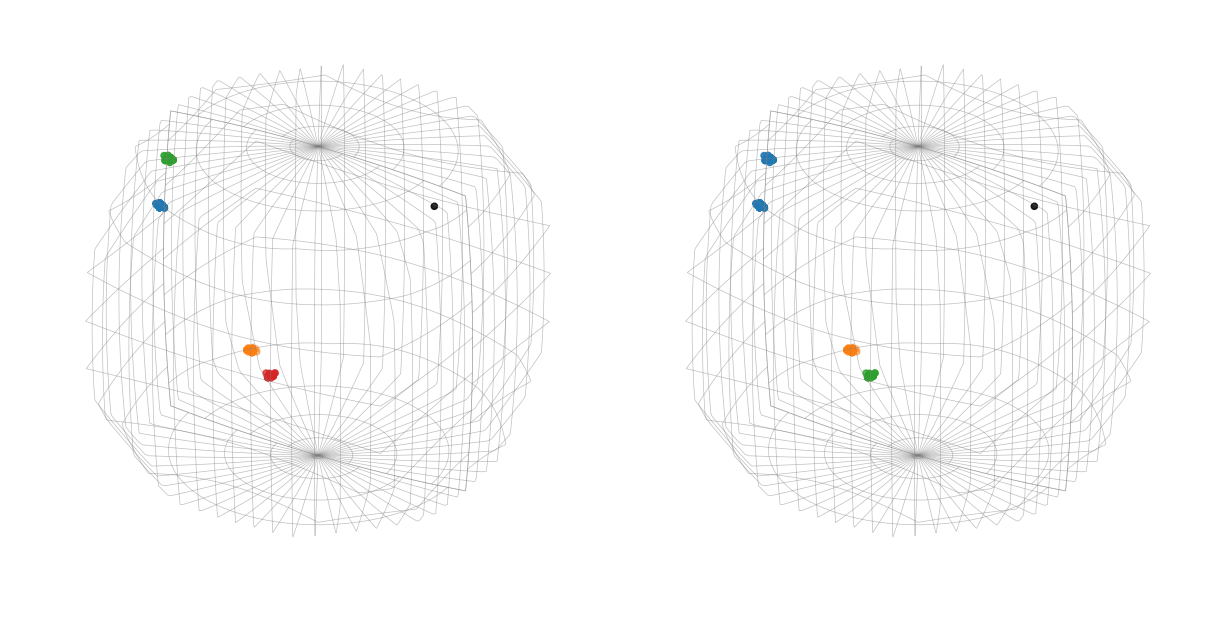

In [112]:
# Set symmetry to "trick" the scatter plot to use the Oh fundamental zone
ori_without_symmetry.symmetry = ori.symmetry

# Create figure with a height/width ratio of 1/2
fig = plt.figure(figsize=(12, 6))

# Add the fundamental zones with clusters to the existing figure
ori_without_symmetry.scatter(figure=fig, position=(1, 2, 1), c=colors_naive)
ori.scatter(figure=fig, position=122, c=colors)
